###Installing required packages

In [174]:
!pip install yfinance pandas matplotlib numpy seaborn cvxpy --quiet

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp
from datetime import datetime

In [177]:
#Load Module 1 macro signal output
macro_path = '/content/drive/MyDrive/Fintech-Project/data/module1c_output.csv'
macro_df = pd.read_csv(macro_path, index_col=0, parse_dates=True)

<ipython-input-177-5023e5047217>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  macro_df = pd.read_csv(macro_path, index_col=0, parse_dates=True)


In [180]:
print(macro_df.columns)

Index(['Date', 'Actual_Inversion', 'Predicted_Probability',
       'Predicted_Inversion'],
      dtype='object')


### ✅Define assets to optimize (example ETFs) and Downloading price data

In [181]:
tickers = ['SPY', 'AGG', 'GLD']  # Stocks, Bonds, Gold
macro_df['Date'] = pd.to_datetime(macro_df['Date'])
start_date = macro_df['Date'].min().strftime('%Y-%m-%d')
end_date = macro_df['Date'].max().strftime('%Y-%m-%d')

In [182]:
price_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)
returns = price_data['Adj Close'].pct_change().dropna()

[*********************100%***********************]  3 of 3 completed


In [184]:
#Aligning with macro_df by date
macro_df['Date'] = pd.to_datetime(macro_df['Date'])
macro_df.set_index('Date', inplace=True)


aligned_df = macro_df.join(returns, how='inner')

In [185]:
tickers = ['SPY', 'AGG', 'GLD']

In [186]:
aligned_returns = aligned_df[tickers].copy()
print(aligned_returns.columns)

Index(['SPY', 'AGG', 'GLD'], dtype='object')


### Calculating mean and covariance

In [187]:
aligned_returns = aligned_df[tickers].copy()
mean_returns = aligned_returns.mean().values        # shape (3,)
cov_matrix = aligned_returns.cov().values           # shape (3, 3)


###Define optimization variables and problem

In [188]:
n_assets = len(tickers)
weights = cp.Variable(n_assets)

In [189]:
print(mean_returns.shape)     # should be (3,)
print(weights.shape)          # should be (3,)
print(cov_matrix.shape)       # should be (3, 3)

(3,)
(3,)
(3, 3)


###Portfolio Optimizating Logic

In [190]:
# Macro-aware gamma adjustment
base_gamma = 0.1
latest_macro_risk = macro_df['Predicted_Probability'].iloc[-1]  # most recent macro risk
gamma = base_gamma + 2 * latest_macro_risk  # dynamic risk aversion
print(f"Macro-adjusted gamma: {gamma:.4f}")

# Portfolio optimization with realistic constraints
expected_return = cp.matmul(mean_returns, weights)
risk = cp.quad_form(weights, cov_matrix)

objective = cp.Minimize(risk - gamma * expected_return)

# Add real-world constraints (diversified portfolio)
constraints = [
    cp.sum(weights) == 1,
    weights >= 0.05,    # minimum 5% in any asset
    weights <= 0.6      # maximum 60% in any asset
]

prob = cp.Problem(objective, constraints)
prob.solve()

Macro-adjusted gamma: 1.0595


np.float64(-0.004212364357140175)

### Outputing optimal Weights

In [191]:
optimal_weights = weights.value
portfolio = pd.Series(optimal_weights, index=tickers)
print("\n📊 Optimal Asset Weights:")
print(portfolio.round(4))


📊 Optimal Asset Weights:
SPY    0.35
AGG    0.05
GLD    0.60
dtype: float64


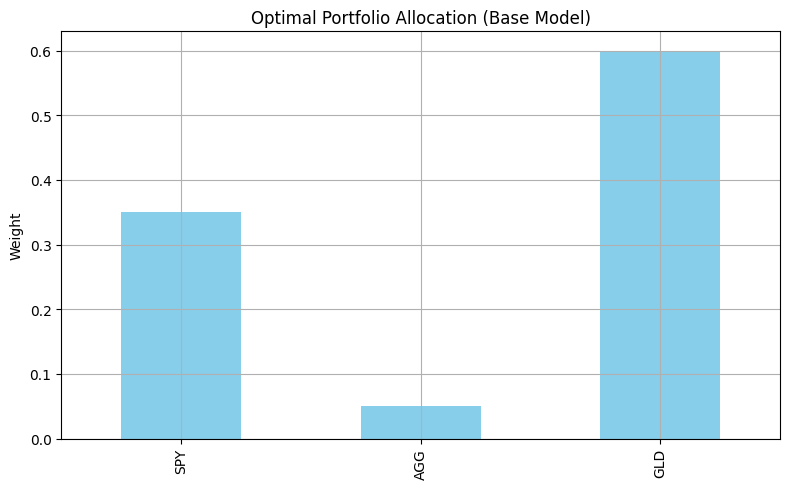

In [192]:
plt.figure(figsize=(8, 5))
portfolio.plot(kind='bar', color='skyblue')
plt.title('Optimal Portfolio Allocation (Base Model)')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Section: Section: Rolling Backtest

####Setup simulation config

In [193]:

#window_size = 60 # rolling window (60 days ~ 3 months)
window_size = 10
weights_history = []
portfolio_returns = []
dates = []

#### Loop through time (rolling optimization)

In [194]:
for i in range(window_size, len(aligned_df) - 1):
    window_returns = aligned_df[tickers].iloc[i - window_size:i]
    macro_risk = aligned_df['Predicted_Probability'].iloc[i]
    next_returns = aligned_df[tickers].iloc[i + 1]

    mu = window_returns.mean().values
    sigma = window_returns.cov().values

    w = cp.Variable(n_assets)
    gamma_dynamic = base_gamma + 2 * macro_risk
    expected = cp.matmul(mu, w)
    variance = cp.quad_form(w, sigma)
    obj = cp.Minimize(variance - gamma_dynamic * expected)
    cons = [cp.sum(w) == 1, w >= 0.05, w <= 0.6]
    prob = cp.Problem(obj, cons)
    prob.solve()

    # ✅ SKIP if solution failed
    if w.value is None:
        continue

    w_val = w.value
    weights_history.append(w_val)
    port_return = np.dot(w_val, next_returns.values)
    portfolio_returns.append(port_return)
    dates.append(aligned_df.index[i + 1])

In [195]:
returns_df = pd.DataFrame(portfolio_returns, index=dates, columns=['Portfolio'])
returns_df['Cumulative'] = (1 + returns_df['Portfolio']).cumprod()

In [196]:
# Compare with benchmark
benchmark = (1 + aligned_df['SPY'].loc[returns_df.index]).cumprod()

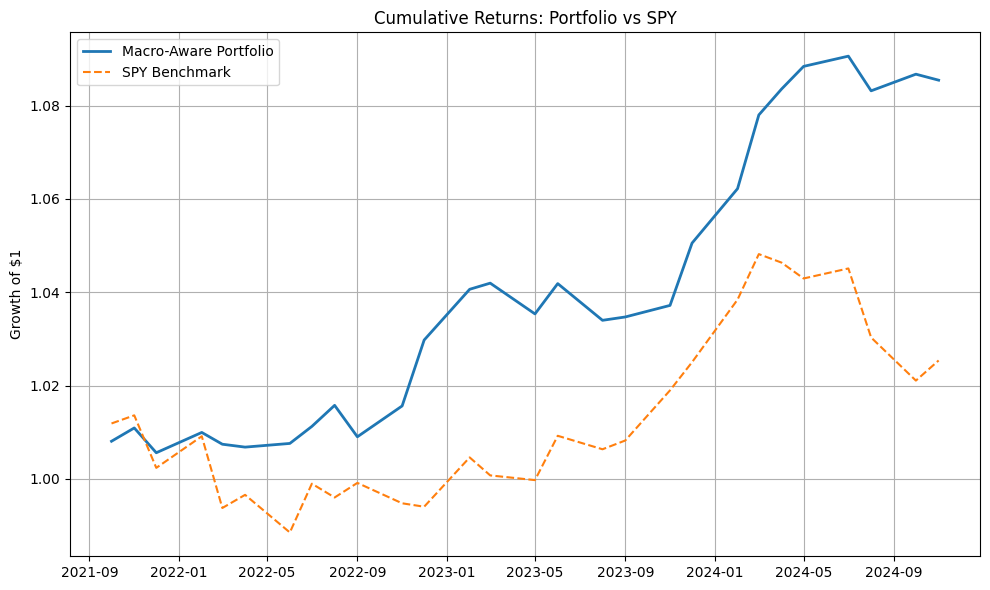

<Figure size 640x480 with 0 Axes>

In [197]:
# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(returns_df['Cumulative'], label='Macro-Aware Portfolio', linewidth=2)
plt.plot(benchmark, label='SPY Benchmark', linestyle='--')
plt.title('Cumulative Returns: Portfolio vs SPY')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.savefig('/content/drive/MyDrive/Fintech-Project/data/portfolio_vs_spy.png', dpi=300)

plt.show()

In [198]:
# Save portfolio returns and weights to CSV
returns_df.to_csv('/content/drive/MyDrive/Fintech-Project/data/module2_portfolio_returns.csv')

# Save weights history if you want to analyze allocation behavior
weights_df = pd.DataFrame(weights_history, index=dates, columns=tickers)
weights_df.to_csv('/content/drive/MyDrive/Fintech-Project/data/module2_weights_over_time.csv')


In [199]:
#  Load weights history and add synthetic risk score
weights_df = pd.read_csv('/content/drive/MyDrive/Fintech-Project/data/module2_weights_over_time.csv', index_col=0)

# Add risk_score column based on SPY weight (assumption: more SPY = more aggressive)
weights_df['risk_score'] = weights_df['SPY'].clip(0, 1)  # normalize SPY weight to [0, 1]

#  Save as the input needed for Module 3
weights_df.to_csv('/content/drive/MyDrive/Fintech-Project/data/optimal_portfolios.csv')